# EDSA Movie Recommender Systems 2022
© Explore Data Science Academy


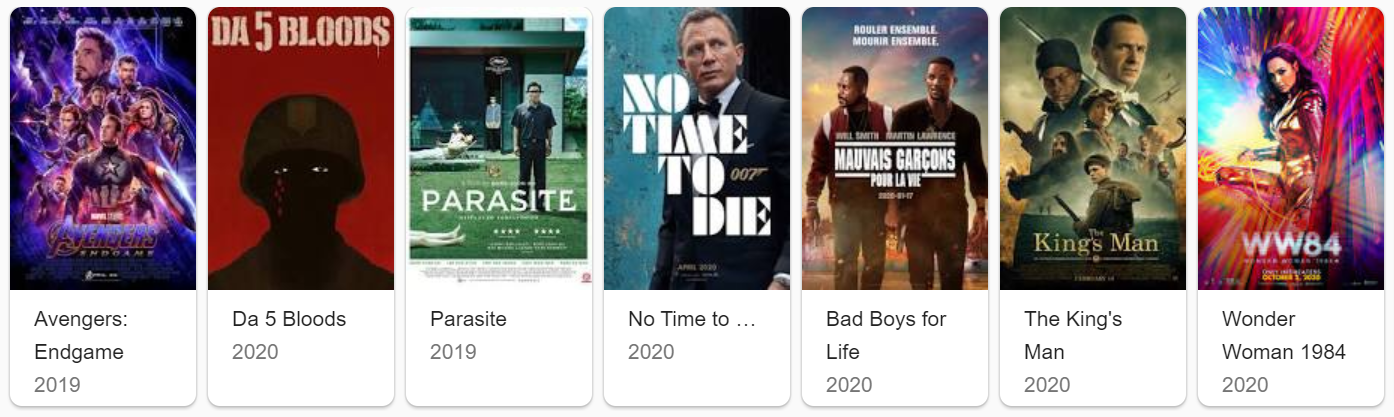

### Honour Code

We {**Team 3**}, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

<a id="cont"></a>
## Table of Contents
<a href=#one>1. Overview
    
<a href=#two>2. Evaluation Metric
    
<a href=#three>3. Comet Experiment
    
<a href=#four>4. Importing Libraries
    
<a href=#five>5. Loading Data
    
<a href=#six>6. Exploratory Data Analysis
    
<a href=#seven>7. Recommender System: Collaborative Filtering
    
<a href=#eight>8. Recommender System: Content Based Filtering
    
<a href=#nine>9. Dimensionality Reduction
    
<a href=#ten>10. Conclusion
    
<a href=#eleven>11. Kaggle Submission

<a id="one"></a>
## 1. Overview
<a href=#cont>Back to Table of Contents</a>


In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.

#### 1.1 Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

#### 1.2 Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

#### 1.3 Supplied files
- genome_scores.csv - a score mapping the strength between movies and tag-related properties
- genome_tags.csv - user assigned tags for genome-related scores
- imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file
- links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs
- sample_submission.csv - Sample of the submission format for the hackathon
- tags.csv - User assigned for the movies within the dataset
- test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
- train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data

 <a id="two"></a>
## 2. Evaluation Metric
<a href=#cont>Back to Table of Contents</a>

---
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

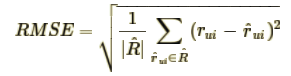 Where 
R
^
 is the total number of recommendations generated for users and movies, with 
r
u
i
 and 
r
^
u
i
 being the true and predicted ratings for user 
u
 watching movie 
i
 respectively.

 <a id="three"></a>
## 3. Comet Experiment
<a href=#cont>Back to Table of Contents</a>

---

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="mmOpPSheJulnOrFlE3B5KW2e1",
    project_name="recommender-systems",
    workspace="deelianne",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/deelianne/recommender-systems/7aac788d30344ebab72f3993da0c9dca



 <a id="four"></a>
## 4. Importing Libraries
<a href=#cont>Back to Table of Contents</a>

---

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')
import surprise
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import SVD
from surprise import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math
#Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
import operator


COMET ERROR: Error logging git-related information


 <a id="five"></a>
## 5. Loading Data
<a href=#cont>Back to Table of Contents</a>

---

In [3]:
#Movies dataframe
movies_df = pd.read_csv('movies.csv')

#Genome_scores dataframe
gs_df = pd.read_csv('genome_scores.csv')

#Genome_tags dataframe
gt_df = pd.read_csv('genome_tags.csv')

#imbd dataframe
imdb_df = pd.read_csv('imdb_data.csv')

#links dataframe
links_df = pd.read_csv('links.csv')

#tags dataframe
tags_df = pd.read_csv('tags.csv')

#train dataframe
train_df = pd.read_csv('train.csv')

#test dataframe 
test_df = pd.read_csv('test.csv')

#sample submission
sample_df = pd.read_csv('sample_submission.csv')

In [4]:
# first five rows of the train dataframe
train_df.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

In [5]:
#dropping the timestamp column
train_df = train_df.drop(columns = 'timestamp', axis = 1)
train_df.head()

userId  movieId  rating
0    5163    57669     4.0
1  106343        5     4.5
2  146790     5459     5.0
3  106362    32296     2.0
4    9041      366     3.0

In [6]:
# first five rows of the test dataframe
test_df.head()

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

 <a id="six"></a>
## 6. Exploratory Data Analysis
<a href=#cont>Back to Table of Contents</a>

---

**Exploratory data analysis (EDA)** is used to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers you need, making it easier to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

EDA is primarily  provides a better understanding of data set variables and the relationships between them. It can also help determine if the statistical techniques you are considering for data analysis are appropriate. 
The main purpose of EDA is to help look at data before making any assumptions. It can help identify obvious errors, as well as better understand patterns within the data, detect outliers or anomalous events, find interesting relations among the variables. [Source](https://www.ibm.com/cloud/learn/exploratory-data-analysis).

We took a deep dive into the statistical analysis of the data, checked its distribution, shape, null values.
Here are some of the analysis we did:

#### 6.1)Ratings distribution

#### 6.2)Ratings distribution by movie

#### 6.3)Ratings distriution by user


In [7]:
# access the data types, and number of observations and features present in the train dataframe
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 228.9 MB


In [8]:
train_df.shape

(10000038, 3)

In [9]:
# check for missing values
train_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

The code above checks for the presence of null values within columns and sums them together. All columns resulted to sums of zero(0), Hence signifying the absence of null values.This check for missing values is important as to determine whether statistical steps like filling the empty rows with either the mean, mode, or median as the case may be required.

In [10]:
# Descriptive statistics of the train data
train_df.describe().T 

count          mean           std  min      25%      50%  \
userId   10000038.0  81199.088145  46793.586156  1.0  40510.0  80914.0   
movieId  10000038.0  21389.111613  39195.781053  1.0   1197.0   2947.0   
rating   10000038.0      3.533395      1.061124  0.5      3.0      3.5   

              75%       max  
userId   121579.0  162541.0  
movieId    8630.0  209171.0  
rating        4.0       5.0

In [11]:
#checking for unique values in the train dataset
train_df.userId.nunique()
train_df.movieId.nunique()

48213

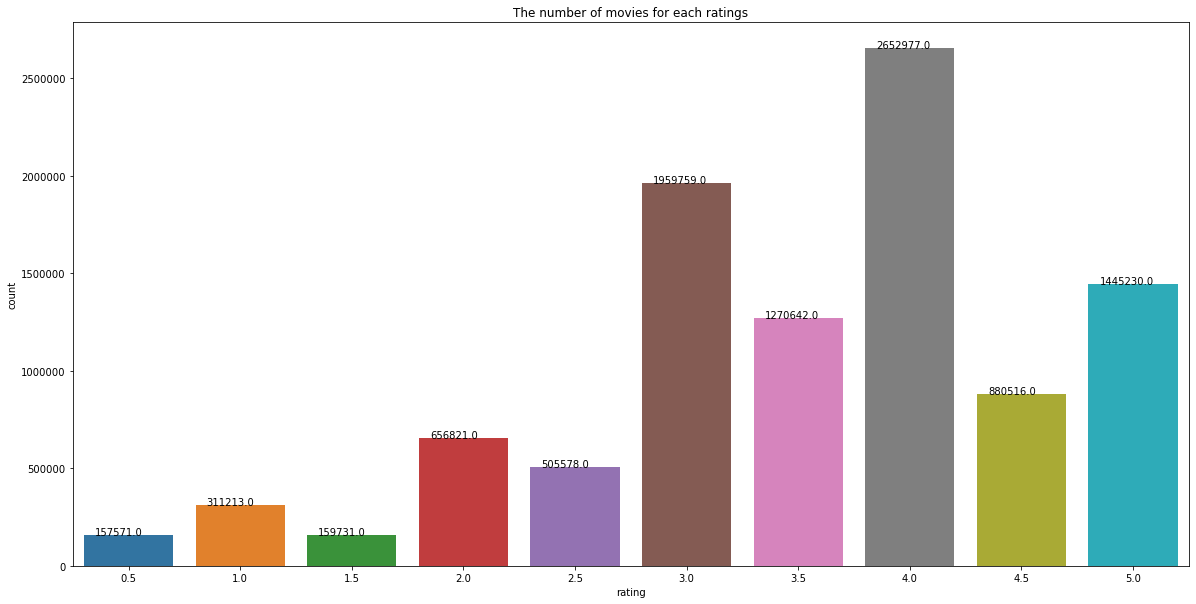

Average rating in dataset: 3.5333951730983424


In [12]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

sns.countplot(ax=ax, x='rating', data=train_df) # Create a countplot to visualise the number of movies per category
ax.set_title("The number of movies for each ratings")
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the tick labels to appear in non-scientific form

# Make the counts appear on the different
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    
# Show the countplot
plt.show()
print (f'Average rating in dataset: {np.mean(train_df["rating"])}')

The figure above shows the distribution of movie ratings. Generally, users were generous when rating movies they had seen with 4.0 being the most occuring rating given to a movie. we could conclude that most movies were given positive reviews. 

### 6.1) Ratings Distribution

In [10]:
#movie ratings distribution as a percentage
data = train_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / train_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie-ratings'.format(train_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 26% of all ratings in the data is 4, and very few ratings are 0.5, 1.0, 1.5, 2.5 and 3.0. **Lowly rated** movies mean that they are generally really bad and not highly recommended by users.

In [29]:
# number of times each rating appears
train_df.rating.value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

### 6.2) Ratings Distribution By Movie

In [12]:
# Number of ratings per movie
data = train_df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per movie (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [13]:
# check the highest number of rating for a movie
train_df.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending = False)[:100]

movieId  rating
314       318   32831
351       356   32383
292       296   31697
585       593   29444
2479     2571   29014
...       ...     ...
109       111   11600
5307     5418   11577
903       924   11562
579       587   11468
762       778   11427

[100 rows x 2 columns]

The above dataframe shows the total number of times a particular movie was rated by different users.We can see that the movie with moviedId  **318** was highly rated by users, being rated about **32831** times.

In [14]:
#check the lowest number of rating for a movie
train_df.groupby('movieId')['rating'].count().reset_index().sort_values('rating')[:100]

movieId  rating
48212   209171       1
31518   152743       1
31516   152737       1
31515   152733       1
31514   152731       1
...        ...     ...
31427   152397       1
31415   152350       1
31412   152344       1
31410   152338       1
31409   152336       1

[100 rows x 2 columns]

We can see how poorly rated some movies were. From the above dataframe, several movies were rated just once(1) by a single user. This may not be of help as it doesn't signify a great power for movie recommendation.

### 6.3) Ratings Distribution By User

In [30]:
# Number of ratings per user
data = train_df.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [31]:
#check the user with the highest rating
train_df.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:100]


userId  rating
72314    72315   12952
80973    80974    3680
137292  137293    3588
33843    33844    3208
20054    20055    3050
...        ...     ...
115899  115900    1318
72355    72356    1305
106506  106507    1302
144713  144714    1299
158108  158109    1295

[100 rows x 2 columns]

The most productive user with a **userId** of **72315** gave ratings of movies for about **12952** times.

In [17]:
#check the user with the lowest rating
train_df.groupby('userId')['rating'].count().reset_index().sort_values('rating')[:100]


userId  rating
105713  105714       1
53639    53640       1
127097  127098       1
121070  121071       1
55361    55362       1
...        ...     ...
14907    14908       3
50543    50544       3
43623    43624       3
80435    80436       3
19199    19200       3

[100 rows x 2 columns]

from here, we can see that users rarely rated movies, with several users rating movies just once(1). This shows the lack of productivity in rating movies.

 <a id="seven"></a>
## 7. Recommender Systems: Collaborative Filtering
<a href=#cont>Back to Table of Contents</a>

---

### 7.1) Surprise
Surprise is an open-source Python library that makes it easy for developers to build recommender systems with explicit rating data.

**Create a Surprise Dataset**

In order to train recommender systems with Surprise, we need to create a Dataset object. A Surprise Dataset object is a dataset that contains the following fields in this order:
The user IDs
The item IDs (in this case the IDs for each movie)
The corresponding rating (usually on a scale such as 1–5)




### 7.2)  Selection of some subset of the data

For the purpose of checking which algorithm performs best, we  will select only a few subset of the whole data set.To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated books and rarely rating users. This section will be done to run a basic cross validation to view how the respective models from the surprise library performed on the same set of data.We will be using about five different algorithms from the surprise library. Having a huge observation of about 10million would be time consuming and as such, a threshold of 1000 would be set, to select only those users that have rated movies atleast 1000 times and for such movies that have also been rated 1000 times.

In [18]:
#extracting movies with user ratings count greater than 1000
min_movie_ratings = 1000
extract_movies = train_df['movieId'].value_counts() > min_movie_ratings
extract_movies = extract_movies[extract_movies].index.tolist()

min_user_ratings = 1000
extract_users = train_df['userId'].value_counts() > min_user_ratings
extract_users = extract_users[extract_users].index.tolist()

train_new = train_df[(train_df['movieId'].isin(extract_movies)) & (train_df['userId'].isin(extract_users))]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(train_new.shape))

The original data frame shape:	(10000038, 3)
The new data frame shape:	(113481, 3)


In [19]:
reader = Reader()

In [20]:
df = train_new[['userId', 'movieId', 'rating']]
df_data = Dataset.load_from_df(df, reader)

In [21]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, df_data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8091  0.8089  0.8113  0.8097  0.0011  
Fit time          10.42   8.86    8.91    9.40    0.72    
Test time         0.94    0.59    0.48    0.67    0.20    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8268  0.8312  0.8278  0.8286  0.0019  
Fit time          9.66    9.49    9.46    9.54    0.09    
Test time         0.94    0.56    0.44    0.65    0.21    
Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4108  1.4069  1.4055  1.4077  0.0023  
Fit time          0.23    0.22    0.23    0.23    0.00    
Test time         0.57    0.58    0.49    0.54    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simila

test_rmse  fit_time  test_time
Algorithm                                      
SVD               0.809742  9.400452   0.669580
BaselineOnly      0.816764  0.305520   0.402686
NMF               0.828586  9.537308   0.646427
KNNBasic          0.904087  0.346605   5.337775
NormalPredictor   1.407703  0.228221   0.544863

From the above dataframe, The SVD algorithm gave us the best test_rmse when compared to other models trained on the subset of the data. Therefore,while going forward, we will train and predict with the SVD using the full data set.



## Train and Predict

**Training and Cross-Validating a Simple SVD Model**

We can train and cross-validate a model that performs SVD (singular value decomposition) in order to build a recommendation system in just a few lines of code. SVD is a popular matrix factorization algorithm that can be used for recommender systems.
Recommender systems that use matrix factorization generally follow a pattern where a matrix of ratings is factored into a product of matrices representing latent factors for the items (in this case movies) and the users.

![image.png](attachment:image.png)

Considering the figure above, notice how the rating matrix, R, has missing values in some places. The matrix factorization algorithm uses a procedure such as gradient descent to minimize the error when predicting existing ratings using the matrix factors. Thus, an algorithm like SVD builds a recommendation system by allowing us to “fill in the gaps” in the rating matrix, predicting the ratings that each user would assign to each item in the dataset.
Starting with an input matrix A, SVD actually factorizes the original matrix into three matrices as demonstrated in the equation below.

![image-2.png](attachment:image-2.png)

We can map these new matrices to the rating matrix R and the item and user factors Q and P as follows:
![image-3.png](attachment:image-3.png)

In the case of our movie recommendation system, the SVD algorithm will represent the rating matrix as a product of matrices representing the movie factors and user factors respectively.

In [39]:
df_train = train_df[['userId', 'movieId', 'rating']]
df_train.head()

userId  movieId  rating
0    5163    57669     4.0
1  106343        5     4.5
2  146790     5459     5.0
3  106362    32296     2.0
4    9041      366     3.0

We will be building our **SVD model** using the whole train data set. From the cross validation test, the **SVD model**  performed best when compared to other models and it would be further used as the basic model for our collaborative filtering technique method.

In [26]:
#instantiate the reader object
reader = Reader()
data = Dataset.load_from_df(df_train, reader)

In [27]:
data = data.build_full_trainset()

svd = SVD(reg_all = 0.04, lr_all = 0.006, init_std_dev = 0.04, n_epochs = 50, random_state=15, verbose=True)
svd.fit(data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


#### Generating Rating Predictions
Now that we have a trained SVD model, we can use it to predict the rating a user would assign to a movie given an ID for the user(userId) and an ID for the movie(movieId). The code above demonstrates how to do this...

## Kaggle Submission
we will be using our trained SVD model to generate rating predictions for users, after which we'll make a submission on kaggle based on its rmse score.

In [41]:
#load the test csv file
test_df

userId  movieId
0             1     2011
1             1     4144
2             1     5767
3             1     6711
4             1     7318
...         ...      ...
5000014  162541     4079
5000015  162541     4467
5000016  162541     4980
5000017  162541     5689
5000018  162541     7153

[5000019 rows x 2 columns]

In [42]:
predictions = []
for i, row in test_df.iterrows():
    value = (svd.predict(row.userId, row.movieId))
    pred = value[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("submission_3.csv", index=False)

In [71]:
results.head()

Id    rating
0  1_2011  3.310988
1  1_4144  4.321662
2  1_5767  3.770369
3  1_6711  4.217246
4  1_7318  3.301565

## Model Pickling 
we will save our **svd**  model along with their optimal parameters and load them later for reuse.

In [106]:
#instantiate the reader object
reader = Reader()
data = Dataset.load_from_df(train_new, reader)

In [108]:
data = data.build_full_trainset()

svd_model = SVD(reg_all = 0.04, lr_all = 0.006, init_std_dev = 0.04, n_epochs = 50, random_state=15, verbose=True)
svd_model.fit(data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


In [109]:
import pickle

model_save_path = "svd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd_model,file)

### 7.3) Algorithm aprroach for the collaborative recommender system

 In Collaborative-based filtering, we use the similarity measured between users to make recommendations. Using the new subset of the train dataframe known as **train_new** in other to avoid moving into a memory error when computing the utility matrix.

In [44]:
#first five observation of the dataframe
train_new.head()

userId  movieId  rating
62    75830     2713     4.0
140  148291     8810     0.5
330  146221     3248     3.0
588   97452    50872     2.5
591   78616     5419     5.0

In [45]:
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

The train data only has userId, movieId, and rating. In other to make recommendations on certain movies to users, we could easily merge the train dataframe with that of the movies dataframe, both on movieId. That way, the titles of particular movies could be recommended to users based on users preferences.


In [63]:
df_merge = train_new.merge(movies_df,on = 'movieId') # Merges the movie and train_new datasets

In [64]:
#merged dataframe of both the train and movie dataframe
df_merge.head()

userId  movieId  rating               title           genres
0   75830     2713     4.0  Lake Placid (1999)  Horror|Thriller
1   80914     2713     3.0  Lake Placid (1999)  Horror|Thriller
2  125773     2713     4.0  Lake Placid (1999)  Horror|Thriller
3   30111     2713     1.0  Lake Placid (1999)  Horror|Thriller
4   41608     2713     1.5  Lake Placid (1999)  Horror|Thriller

In [65]:
util_matrix = df_merge.pivot_table(index=['userId'], 
                                        columns=['title'],
                                        values='rating') 
util_matrix.shape

(220, 2117)

The utility matrix is sparse, as it is unlikely that a user has seen many of the movies within the entire dataframe.

In [66]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]

# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

We can now compute the similarity between users based on the ratings they have given various movies

In [67]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)

# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                            index = util_matrix_norm.columns, 
                            columns = util_matrix_norm.columns)

# Review a small portion of the constructed similartiy matrix  
user_sim_df[:5]

userId    548       847       1748      2177      2982      3150      5114    \
userId                                                                         
548     1.000000  0.065940  0.074453  0.103275  0.138011  0.096370  0.063899   
847     0.065940  1.000000  0.014126  0.083660  0.090318  0.082802  0.026475   
1748    0.074453  0.014126  1.000000  0.099951  0.052693  0.024196  0.000208   
2177    0.103275  0.083660  0.099951  1.000000  0.144701  0.064209  0.030107   
2982    0.138011  0.090318  0.052693  0.144701  1.000000  0.102370  0.042959   

userId    5572      8619      9620    ...    152690    153086    156183  \
userId                                ...                                 
548     0.021526  0.098447  0.062101  ...  0.127410  0.326004  0.006863   
847     0.066637  0.118645  0.011774  ...  0.134800  0.038093  0.018163   
1748   -0.018398  0.062116  0.033724  ...  0.054514  0.046568  0.013162   
2177    0.046999  0.134547  0.145152  ...  0.144190  0.067593 -0.014270   
2982    0.068371  0.210767  0.085931  ...  0.230690  0.139217  0.010731   

userId    156480    158109    159816    160747    162047    162271    162516  
userId                                                                        
548     0.022705 -0.021910  0.060795  0.048983  0.086491  0.033315  0.116586  
847     0.044928 -0.002394  0.056080  0.118760  0.056612  0.065895  0.039996  
1748    0.055281  0.036786  0.050845  0.010970  0.043648 -0.025252  0.017917  
2177    0.001005 -0.044333  0.059853  0.074181  0.068199  0.035954  0.070035  
2982    0.011399  0.017930  0.087523  0.095000  0.146117  0.093078  0.096450  

[5 rows x 219 columns]

With our similarity matrix formed, we are once again in a position to make some recommendations. we'll first look at generating top-N recommendations

#### Top-N Recommendations

In order to produce a list of top-N recommendations for collaborative filtering, the following simple algorithm can be followed: 

  1. Select an initial reference user to generate recommendations for. 
  2. Extract all the similarity values between the reference user and each other user in the similarity matrix.
  3. Sort the resulting similarity values in descending order, and select the $k$ most similar users based on these values.  
  5. For each selected user, collect their top-rated items. 
  6. Form a tally of which items are most popular across the $k$ similar users. Do this by counting how many times a top-rated item is common amongst the other users. 
  7. Sort the top-rated items according the the popularity tally. Return the top-N values as the result. 
    
  
We implement this algorithmic process in the function below:

In [69]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
     # Cold-start problem - no ratings given by the reference user. 
     # With no further user data, we solve this by simply recommending
     # the top-N most popular books in the item catalog. 
    if user not in user_sim_df.columns:
         return df_merge.groupby('title').mean().sort_values(by='rating',
                                         ascending=False).index[:N].to_list()
    
     # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users
    
    for i in sim_users:
         # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
         # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())
        
     # Loop over each user's favorite items and tally which ones are 
     # most popular overall.
    for item_collection in range(len(favorite_user_items)):
         for item in favorite_user_items[item_collection]: 
            if item in most_common_favorites:
                 most_common_favorites[item] += 1
            else:
                 most_common_favorites[item] = 1
     # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N  

With our algorithm defined, we can now go ahead and search for recommended movies for a particular user.

In [56]:
# Our recommended list for user 548
collab_generate_top_N_recommendations(548)

['Wizard of Oz, The (1939)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Aliens (1986)',
 'Back to the Future (1985)',
 'Edward Scissorhands (1990)',
 'Lost Highway (1997)',
 'Shawshank Redemption, The (1994)',
 'Big Lebowski, The (1998)',
 'Platoon (1986)',
 'Pulp Fiction (1994)']

In [70]:
# User 548's movie ratings
df_merge[df_merge['userId'] == 548][:][['title','rating']].sort_values(by='rating', ascending=False)[:10]

title  rating
59190                               Papillon (1973)     5.0
4417                                 Platoon (1986)     5.0
81205                         Lion King, The (1994)     5.0
10628                      Big Lebowski, The (1998)     5.0
9017                       Wizard of Oz, The (1939)     5.0
74026   Indiana Jones and the Temple of Doom (1984)     5.0
111285                   Sound of Music, The (1965)     5.0
60462                     Driving Miss Daisy (1989)     4.5
97189                          28 Days Later (2002)     4.5
52505                                Memento (2000)     4.5

<a id="eight"></a>
## 8. Recommender Systems: Content- Based Filtering
<a href=#cont>Back to Table of Contents</a>

---
Content-based filtering is a type of recommender system that attempts to guess what a user may like based on that user’s activity.

Content-based filtering makes recommendations by using keywords and attributes assigned to objects in a database (e.g., items in an online marketplace) and matching them to a user profile. The user profile is created based on data derived from a user’s actions, such as purchases, ratings (likes and dislikes), downloads, items searched for on a website and/or placed in a cart, and clicks on product links.

**Assigning attributes**

Content-based filtering relies on assigning attributes to database objects so the algorithm knows something about each object. These attributes depend primarily on the products, services, or content you’re recommending.

Assigning attributes can be a monumental undertaking. Many companies resort to using subject-matter expert teams to assign attributes to each item manually. For example, with both the train and the movie dataset, we can merge the tables and show the ratings the users gave different movies and the count of those ratings. The resulting tags, used by the recommender, are algorithmically combined to group films together that share similar aspects.

This method relies heavily on the similarities between features and relies on the feature matrix to compute the similarities between each features. The similarities are obtained by finding the distance using the cosine distance metric.

Cosine distance metric is calculated using the dot product of 2 vectors over their norms. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have the length 1.

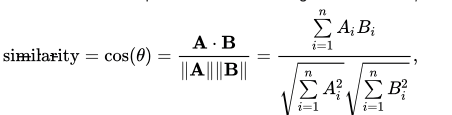
As an angle becomes smaller (approaching 
0
o
) the value of its cosine increases. Conversely, as the angle increases the cosine value decreases. It turns out that this behavior makes the cosine of the angle between two p-dimensional vectors desirable as a similarity metric which can easily be computed.

The data must be transformed into a feature matrix so that the similarities occurred.

**Building a user profile**

User profiles are another element crucial to content-based recommender systems. Profiles include the database objects the user has interacted with—purchased, browsed, read, watched, or listened to—as well as their assigned attributes.

Attributes appearing across multiple objects are weighted more heavily than those that show up less often. This helps establish a degree of importance because not all of an object’s attributes are equal to the user. User feedback is also critical when weighting items, which is why websites  that provide recommendations are continually asking you to rate products, services, or content.

Based on attribute weightings and histories, the recommender system produces a unique model of each user’s preferences. The model consists of attributes the user is liable to like or dislike based on past activities, weighted by importance. User models are compared against all database objects, which are then assigned scores based on their similarity to the user profile.

Here’s an example: Let’s say you watched Netflix's "Me Before You", " The Notebook" and "365 Days". A recommender system might recognize that you like romantic movies. You could expect to receive recommendations for more romantic Netflix movies.”

The recommender system may also suggest different types of movies related to the ones you watched . Still, since you didn’t choose to watch those movies, their selections would receive a lower assigned score.

Content based filtering has more benefits including:

**i)No data from other users is required to start making recommendations** Once a user has searched on and browsed a few items and/or completed some purchases, a content-based filtering system can begin making relevant recommendations. This makes it ideal for businesses that don’t have an enormous pool of users to sample. It also works well for sellers that have many users but a small number of user interactions in specific categories or niches.

**ii) Recommendations are highly relevant to the user.** Highly relevant recommendations project a sense of openness to the user, bolstering their trust level in offered recommendations.

**iii) You avoid the “cold start” problem.** Although content-based filtering needs some initial inputs from users to start making recommendations, the quality of early recommendations is generally better than a collaborative system that requires the addition and correlation of millions of data points before becoming optimized.

**iv) Content-based filtering systems are generally easier to create.** Content-based filtering system is relatively straightforward compared to collaborative filtering systems intended to mimic user-to-user recommendations. The real work in content-based filtering is assigning the attributes.

Recommender systems such as content-based filtering benefit both users and movie producers. Users can spend less time searching through websites of different movies in an online streaming service. Service providers can better understand user preferences, provide a more personalized user experience, increase sales, and build brand loyalty by using content-based filtering.

In [93]:
#train dataframe
train_df = pd.read_csv('train.csv')

In [94]:
#Checking for users average rating
train_df1 = pd.DataFrame(train_df.groupby('userId')['rating'].agg('mean').reset_index())
train_df2 = pd.DataFrame(train_df.groupby('userId')['rating'].count().reset_index())

In [95]:
#Merge train_df1 and train_df2
train_df1 = train_df1.merge(train_df2,on='userId',how = 'left')

In [96]:
# Rename the columns respectively
train_df1.rename(columns={'rating_x':'avg_rating','rating_y':'number_of_movies'},inplace = True)

In [97]:
# Sort the data in descending order of the number of movies the user has rated
train_df1 = train_df1.sort_values('number_of_movies', ascending = False)
train_df1.head()

userId  avg_rating  number_of_movies
72314    72315    3.092380             12952
80973    80974    3.277582              3680
137292  137293    3.192168              3588
33843    33844    2.583853              3208
20054    20055    3.179016              3050

Having sorted the dataframe in descending order, the user with userId of **72315** appears to be the most productive user having given a rating of about **129592** times.

In [98]:
train_movies = train_df.merge(movies_df,on = 'movieId') # Merges the movie and train datasets
train_movies.drop(columns=['timestamp'],inplace=True) # Dropping the timestamp column
train_movies.head(10) # Shows the first 10 observations

userId  movieId  rating             title                       genres
0    5163    57669     4.0  In Bruges (2008)  Comedy|Crime|Drama|Thriller
1   87388    57669     3.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
2  137050    57669     4.0  In Bruges (2008)  Comedy|Crime|Drama|Thriller
3  120490    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
4   50616    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
5   99887    57669     0.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
6  120194    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
7     847    57669     3.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
8   47201    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller
9   94499    57669     4.5  In Bruges (2008)  Comedy|Crime|Drama|Thriller

In [99]:
# Create a new dataframe from the train_movies dataframe to get the average rating  
train_2 = train_movies.copy()

# Drop any duplicated information 
train_2.drop_duplicates(['title','genres'],inplace = True)

# Get the  avarage rating for each movie in the data 
total_ratings = train_movies.groupby(['movieId','genres']).mean()['rating'].reset_index()

# Merge the train2 and the total_ratings to create a new dataframe 
train_2 = train_2.merge(total_ratings, on = 'movieId')

train_2.drop(columns=['userId','rating_x','genres_y'],inplace=True) # Delete the duplicated columns

train_2.rename(columns={'genres_x':'genres','rating_y':'rating'},inplace=True) # Rename the columns

# Show the  first 5 observations
train_2.head()

movieId                                              title  \
0    57669                                   In Bruges (2008)   
1        5                 Father of the Bride Part II (1995)   
2     5459  Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...   
3    32296     Miss Congeniality 2: Armed and Fabulous (2005)   
4      366  Wes Craven's New Nightmare (Nightmare on Elm S...   

                          genres    rating  
0    Comedy|Crime|Drama|Thriller  3.889842  
1                         Comedy  3.059165  
2           Action|Comedy|Sci-Fi  3.004276  
3         Adventure|Comedy|Crime  2.535714  
4  Drama|Horror|Mystery|Thriller  2.972609

In [100]:
train_3 = train_2.copy() # Make a copy of the train_2 dataset
# Create a user dataset to check how many time it has been voted for
user_rated = pd.DataFrame(train_df['movieId'].value_counts().reset_index()) # Create a user dataframe using groupby function

user_rated.rename(columns = {'index':'movieId','movieId':'voted'},inplace = True) # Rename the columns 

train_3 = train_3.merge(user_rated, on ='movieId') # Combine the train3 dataset with the User_rated data

# Filter the data 
train_3 = train_3[train_3['voted'] > 10] # Find the movies which have the us voted for more than 10 

train_3 = train_3.sort_values('rating',ascending=False) # Sort the values by the rating feature

train_3.head() # Show the first 5 observations 

movieId                   title              genres    rating  voted
18499   174551        Obsession (1965)              Comedy  4.772727     11
5148    171011  Planet Earth II (2016)         Documentary  4.517084    439
1152    171705        Den radio (2001)  (no genres listed)  4.500000     13
2660    159817     Planet Earth (2006)         Documentary  4.473294    674
9966    171495                  Cosmos  (no genres listed)  4.456897    116

In [41]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

movieId     genres
0        1  Adventure
1        1  Animation
2        1   Children
3        1     Comedy
4        1    Fantasy

### Movie Genre Analysis

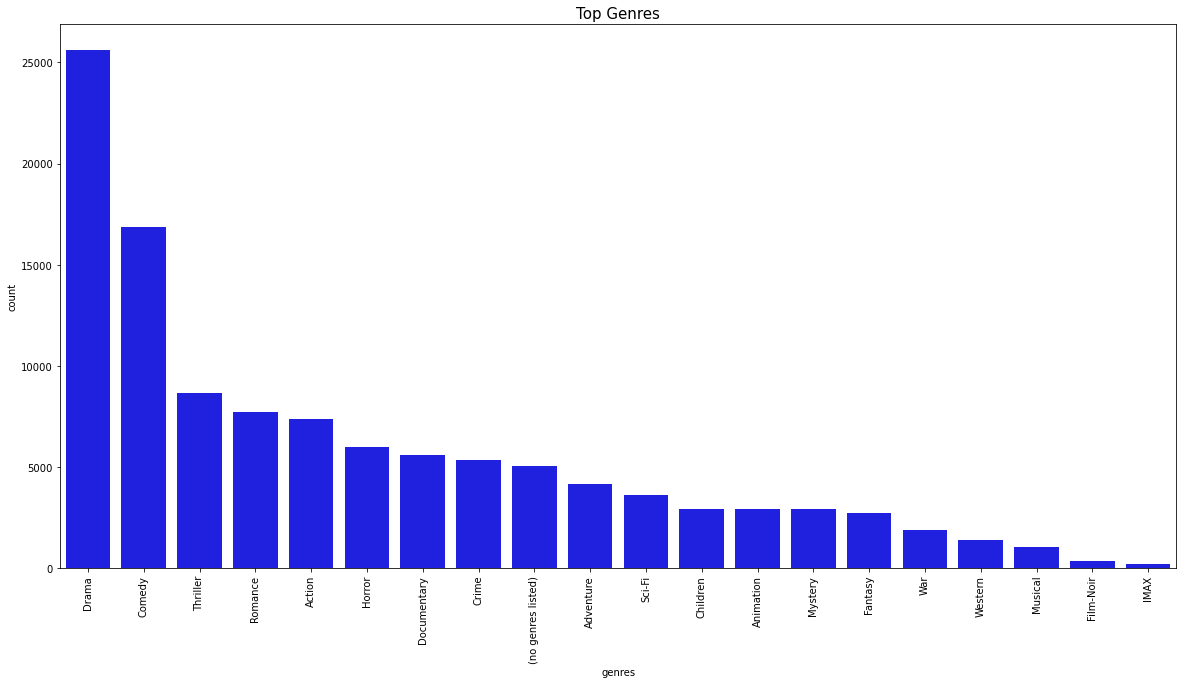

In [42]:
# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = movies_genres['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='blue')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.style.use("dark_background")
plt.show()

The plot shows that **Drama** genre is the most recommended movie having a count of more than 25000 with **Imax** being the least recommended. Users seem to prefer items(movies) whose contents are **dramatic**, filled with **comedy** and a little bit **horrific** and as such, these contents(genre) seem to be likely recommended to users. 

### Data Preprocessing
Prepare data for use within Content filtering algorithm. The preproceesing function will return a dataframe of the subset of movies selected for content-based filtering


In [102]:
def data_preprocessing(subset_size):
    movies = movies_df.copy()
    # Split the genres feature so that each genres will be in a list format 
    movies['genres'] = movies.genres.str.split('|')

    #Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
    moviesWithGenres_df = movies.copy()

    #For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
    for index, row in movies.iterrows():
        for genre in row['genres']:
            moviesWithGenres_df.at[index, genre] = 1
    #Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
    moviesWithGenres_df = moviesWithGenres_df.fillna(0)
    moviesWithGenres_df.drop(['genres'],axis =1, inplace = True)
    # Slice the data
    movie_subset = moviesWithGenres_df[:subset_size]

    return movie_subset

The preprocessed data will then be used to run the recommendation model based on the Nearest neighbor.

**The Nearest Neighbor** method is a good example of a “general approximator” that is entirely based on patterns in the data, without any specific “statistical model” that must be estimated. In fact, k-nearest neighbor methods do not rely on any “models” at all but instead simply use the existing data (or a sample of exemplars from the existing data) to “predict” new observations. Specifically, when predicting a new observation, the algorithm finds the most similar observations among the exemplars with respect to the available predictors and then makes the prediction that the new observation will have the same outcome (same predicted y, or predicted classification).

NearestNeighbors acts as a uniform interface to three different nearest neighbors algorithms: BallTree, KDTree, and a brute-force algorithm based on distance metrics for an example, cosine distance metric. The choice of neighbors search algorithm is controlled through the keyword 'algorithm', which must be one of ['auto', 'ball_tree', 'kd_tree', 'brute'].

For the content- based recommender system, we used the Brute algorithm.

The Brute algorithm  involves the brute-force computation of distances between all pairs of points in the dataset: for samples in dimensions, this approach scales as time complexity is quadratic as it in data size.

For the dataset, the below function performs content filtering based on a list of movies supplied by the user of the app. The function takes a list of movies chosen by the user and returns the top recommended movies to the user.

In [103]:
def content_model(movie_list,top_n=10):
    # Initializing the empty list of recommended movies
    recommended_movies = []
    # Preprocess the data 
    data = data_preprocessing(27000)

    # Create a new DataFrame
    data2 = data.copy()

    # Change the index of the DataFrame
    data2 = data2.set_index('title')

    # Delete the columns the unneccesary columns 
    data.drop(['title'],axis = 1,inplace=True)
    
    # Generating the count matrix for each genres
    data = data.set_index('movieId')

    # Instantiating the model and fitting the model to the count matrix
    nn = NearestNeighbors(algorithm='brute',metric='cosine',n_neighbors=10)
    nn.fit(data)

    # Create an Empty list for the movieids
    movieids = []

    # Getting the movieids
    ind1 = data2.loc[movie_list[0],'movieId']
    ind2 = data2.loc[movie_list[1],'movieId']
    ind3 = data2.loc[movie_list[2],'movieId']

    # Adding the movieids to the list
    movieids.extend([ind1,ind2,ind3])
    # Setting a list of indexes
    index_list = []

    # Getting the suggestions in form of indexes
    for i in range(len(movieids)):
        distances,suggestions=nn.kneighbors(data.loc[movieids[i],:].values.reshape(1,-1),n_neighbors=15)

        for j in range(15):
            index_list.append(suggestions[0,j])

    # Creating an empty list to store the movie ids 
    movieids2 = []
    
    # Create a for loop get the titles of the movies
    for i in range(len(index_list)):
        id = data.index.values[index_list[i]]
        movieids2.append(id)

    # Create a list to store all the titles
    title_list = []

    # Create a new dataframe to get the titles of the movies and change the index to movieId 
    data3 = data_preprocessing(27000)
    data3 = data3.set_index('movieId')

    for i in range(len(movieids2)):
        title = data3.loc[movieids2[i],'title']
        if(title not in movie_list):
            title_list.append(title)

    # recommended movies 
    recommended_movies.extend(random.sample(title_list,k = top_n))
    return recommended_movies

In [104]:
from sklearn.neighbors import  NearestNeighbors

# Packages for Randomisation
import random

### Demostrating the effectiveness of the recommendation system

In [105]:
# Declare a movie list 
movielist = ["Shrek the Third (2007)","Shrek the Third (2007)","Santa Claus: The Movie (1985)"]

# Run the recommendation
recommendation = content_model(movielist,5)

print(recommendation)

['Toy Story Toons: Small Fry (2011)', 'Toy Story (1995)', 'Toy Story Toons: Hawaiian Vacation (2011)', 'Toy Story (1995)', 'Toy Story 2 (1999)']


<a id="nine"></a>
## 9. Dimensionality Reduction
<a href=#cont>Back to Table of Contents</a>

---


A widely encountered problem in machine learning is that of dimensionality. We typically refer to the size or shape of a dataset as an  𝑛
n
  x  𝑝
p
  matrix, where each row from 1 to  𝑛
n
  represents an observation, or data point, and each column from 1 to  𝑝
p
  represents a variable, or feature. With each additional feature, the dimensionality of a dataset increases by 1.

The problems with increasing or high levels of dimensionality are as follows:

i) More storage space required for the data

ii) More computation time required to work with the data

iii)More features mean more chance of feature correlation, and hence feature redundancy.

The latter point is the basis on which principal component analysis is carried out. A feature that is highly correlated with another increases when the other increases (positive correlation), or decreases when the other increases (negative correlation). This is helpful, because if multiple features tend to behave in a corresponding manner in the dataset, they can often be replaced by some smaller quantity of representative feature(s). This helps to lower the feature space within which the data reside, reducing computation time as well as storage capacity requirements.

The goal of dimensionality reduction is to reduce the number of features in a dataset while minimising the amount of data loss. There are three primary methods by which this can be done:

**i)Principal Component Analysis (PCA)**

**ii)Linear Discriminant Analysis (LDA)**

**iii)Generalised Discriminant Analysis (GDA)**

In this notebook we will focus on PCA.

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated movies and rarely rating users.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [54]:
# Scaling the movies_df
features = [col for col in train_df.columns] # declare the features to be all columns from our movies_df

# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
scaled_df = pd.read_csv('train.csv')
scaled_df[features] = preprocessing.scale(scaled_df[features])

In [56]:
from sklearn.decomposition import PCA

Text(0, 0.5, 'Cumulative explained variance')

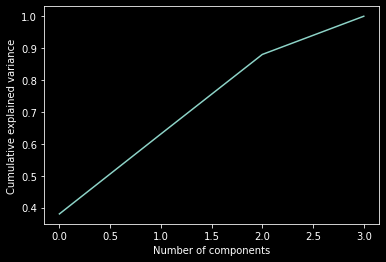

In [57]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(scaled_df[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)



# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [58]:
pca_85 = PCA(.85)
pca_85.fit_transform(scaled_df[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

88.0 % of variance explained by 3 components.


In [59]:
pca.explained_variance_ratio_[:3]

array([0.3802045 , 0.25060905, 0.24947369])

The first principal component is 38%, the 2nd  25% and the 3rd is 24.9%. All the principal components sum up to 88%

**Building Predictive Regressor Model**

We used the rating feature as the response/predictive variable. This feature was used in our initial PCA, so we made changes to the dataset to ensure it is not included when building the predictive model.

We did scale the features first as shown above. The response variable used for prediction was not scaled since it is not used in PCA. This is because not scaling the response means any predicted values and associated errors are easier to interpret.

In [60]:
#sns.scatterplot(x = pca_df[:,0], y = pca_df[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

In [61]:
# exclude non-features from data
reg_data = scaled_df[features]

# set aside response variable (Unscaled!)
reg_response = train_df["rating"]

# drop response variable
reg_data = reg_data.drop(['rating'], 1)

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

We split the dataset with 80% train data and 20% test data

In [65]:
# create PCA object with n_components set to 2
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

2

In [66]:
pca_reg.explained_variance_ratio_.sum()

0.840230197780438

In [67]:
#label = reg_data["label"]
#label.value_counts()

In [68]:
#from sklearn.manifold import TSNE
#tsne = TSNE(n_components = 2, random_state=0)
#tsne_res = tsne.fit_transform(X_train)

#sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

<a id="ten"></a>
## 10. Conclusion
<a href=#cont>Back to Table of Contents</a>

---
With both the recommendater systems, we have shown that the movie streaming websites can continue to serve content while still retaining loyal customers

Online service provision has made it challenging to get to understand a customer on a face to face level. This fact has proven to be a challenge to online businesses since it may not be easy to know customers expectations.

**Solution**

The advances in machine learning and deep learning has possible to get to know millions of customers completely online simply through their digital print. By using a recommender model to filter through your users' favorite products, movies, TV shows and interests, it is easier to make recommendations to them based on their shopping and watching.

Content-based filtering methods are commonly used by businesses. 

A content recommendation system will see what the user already has an interest in, and recommend similar products or items in this case movies. For example the "Surprise Me" button or the "Because you watched..." section on Netflix

Recommender systems became useful features due to their ability to navigate through huge datasets. There is a lot of stuff available online, and many users have a hard time not only finding something they want but even figuring out what it is that they want in the first place. So, the recommender system is a delicate way of bringing users and relevant content together.


All the recommendation system does is narrowing the selection of specific content to the one that is the most relevant to the particular user.

Serving accurate content, building strong relationships all while generating more data for our machine learning models to improve as our service continues. We are confident our solutions will provide our clients with the utmost standard of content tailored to them.

 <a id="eleven"></a>
## 11. Kaggle Submission
<a href=#cont>Back to Table of Contents</a>

---
For the challenge submission, we used used the collaborative filtering for the predictions

In [111]:
#load the test csv file
test = pd.read_csv('test.csv')

In [112]:
predictions = []
for i, row in test.iterrows():
    value = (svd.predict(row.userId, row.movieId))
    pred = value[3]
    predictions.append(pred)
test['Id'] = test['userId'].map(str) +'_'+ test['movieId'].map(str)
results = pd.DataFrame({"Id":test['Id'],"rating": predictions})
results.to_csv("submission_5.csv", index=False)

In [94]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/deelianne/recommender-systems/b44fc0bb7a74407c9966098064f040c1
COMET INFO:   Parameters:
COMET INFO:     algorithm     : brute
COMET INFO:     leaf_size     : 30
COMET INFO:     metric        : cosine
COMET INFO:     metric_params : 1
COMET INFO:     n_jobs        : 1
COMET INFO:     n_neighbors   : 10
COMET INFO:     p             : 2
COMET INFO:     radius        : 1.0
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termin